## Aplicação dos métodos

### Importação

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import sklearn.decomposition
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [79]:
df = pd.read_csv('dados tratados/v1/data.csv')

In [80]:
df = df.drop(['Mau', 'Maa', 'Mag'], axis=1)

In [81]:
df['Abs 1º Pico'] = df['Abs 1º Pico'].replace(np.nan,0)

In [82]:
df['Abs 2º Pico'] = df['Abs 2º Pico'].replace(np.nan,0)

In [83]:
df['Resultado 2'] = list(df['Resultado'].replace('FI','NF'))

### Absorbância 1º Pico

In [7]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:9]
TARGET = ['Abs 1º Pico']
# TARGET = ['Resultado']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [8]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [9]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [10]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [11]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [12]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [13]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [14]:
NUM_EPOCAS = 10000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

9999 tensor(3.3554e-05)


In [15]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [16]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [17]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [18]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 2374.6631130950964


In [19]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {RMSE}')

Loss do teste: 5639024.900694495


### Absorbância 1º e 2º pico

In [8]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:9]
TARGET = ['Abs 1º Pico','Abs 2º Pico']
# TARGET = ['Resultado']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [9]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [10]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [11]:
print(X_treino)
print()
print(y_treino)

tensor([[0.0000, 1.0000, 1.0000, 0.5714, 0.0000, 0.5000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.0521, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.1667, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.5000, 1.0000, 0.0667],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.5000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.5000, 1.0000, 0.0333],
        [0.0000, 0.0000, 0.0000, 0.4286, 1.0000, 0.1667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7917, 0.1667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.8333, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.1042, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.6667, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.5000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.000

In [12]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [13]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [14]:
for p in minha_MLP.parameters():
    print(p)

Parameter containing:
tensor([[-0.3493, -0.3208, -0.2839, -0.1223, -0.3357,  0.2757, -0.0189, -0.0950],
        [-0.0272, -0.3276,  0.1257,  0.0911,  0.3045, -0.0234,  0.2092, -0.0493],
        [-0.2858,  0.3129,  0.2280,  0.0718,  0.0219,  0.2207, -0.1716,  0.1085],
        [ 0.1372, -0.0774,  0.1005,  0.2524, -0.0646,  0.1719,  0.1384,  0.0588],
        [ 0.3222, -0.2119, -0.1714, -0.0032,  0.2530, -0.0541,  0.0456, -0.2937],
        [-0.1953, -0.1431, -0.2490, -0.2600, -0.2934,  0.1813,  0.3169,  0.2739],
        [ 0.2277, -0.1340,  0.3125,  0.0515, -0.0070, -0.3118, -0.0413, -0.0148],
        [ 0.0496,  0.3220, -0.0227, -0.1226, -0.2054,  0.1907, -0.0227,  0.0908],
        [-0.2986,  0.3245, -0.3078,  0.1266,  0.2598,  0.2955, -0.1107, -0.2457],
        [-0.3268,  0.0628,  0.0419,  0.3206, -0.2166, -0.2495, -0.2670, -0.2176],
        [-0.1951, -0.0029,  0.3364, -0.3155,  0.2637,  0.2176,  0.0761, -0.2286],
        [-0.2381,  0.2719,  0.1116, -0.0519,  0.1618, -0.2748, -0.0768, -0.0

In [15]:
y_prev = minha_MLP(X_treino)
y_prev

tensor([[-0.1799, -0.0790],
        [-0.1377, -0.0665],
        [-0.2208,  0.0309],
        [-0.1251, -0.0597],
        [-0.2136,  0.0134],
        [-0.1242, -0.0593],
        [-0.2145,  0.0361],
        [-0.1944,  0.0249],
        [-0.2067, -0.0049],
        [-0.1379, -0.0668],
        [-0.2102,  0.0045],
        [-0.1475, -0.0544],
        [-0.1586, -0.0756],
        [-0.1922,  0.0261],
        [-0.2303,  0.0252],
        [-0.1593, -0.0735],
        [-0.1886, -0.0765],
        [-0.1336, -0.0630],
        [-0.1465, -0.0563],
        [-0.2030, -0.0147],
        [-0.1911,  0.0267],
        [-0.1426, -0.0637],
        [-0.1833,  0.0341],
        [-0.1939,  0.0353],
        [-0.1378, -0.0662],
        [-0.1548, -0.0657],
        [-0.1432, -0.0679]], grad_fn=<AddmmBackward0>)

In [16]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [17]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [18]:
NUM_EPOCAS = 20000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

19999 tensor(5.0437e-08)


In [19]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[3.3300001  4.01600023] [3.32909254 4.0144767 ]
[1.40999997 7.86      ] [1.4095656  7.85852847]
[0.44000001 0.80600002] [0.43960741 0.80611843]
[1.30699996 0.91300001] [1.30615777 0.91227859]
[0.84199998 0.875     ] [0.84167674 0.87488774]
[1.69100001 2.10200009] [1.69026126 2.10089094]
[0.369      0.72000002] [0.36873104 0.71928674]
[0. 0.] [-0.00028172  0.00038712]
[1.28999997 0.87000002] [1.28831353 0.86769743]
[1.34100006 3.19399991] [1.3407779  3.19310813]
[0.78199998 0.82099997] [0.7821056  0.82114175]
[2.65899991 1.44500002] [2.65570342 1.43960287]
[0. 0.] [-1.99481994e-05  2.49208733e-04]
[0.187 0.   ] [ 0.18689559 -0.0006178 ]
[0.38500001 0.77799998] [0.38468183 0.77760304]
[2.95100007 4.03099996] [2.9501323  4.02998052]
[3.65900011 4.08600004] [3.65826354 4.08541396]
[0. 0.] [-1.78715251e-05  2.45519355e-04]
[2.26600001 1.46899995] [2.26857666 1.47449725]
[1.28699998 0.90499998] [1.28766706 0.90599634]
[0.158      0.30500001] [0.15762816 0.30458704]
[2.85899995 3.07799999] [2

In [20]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [21]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[2.81999994 2.57399997] [2.46981797 2.0200563 ]
[0.35399999 0.81499999] [0.36095081 0.71603271]
[2.92599995 3.97300012] [3.03667716 3.93358959]
[2.13000009 2.82999997] [2.14025674 3.25298897]


In [22]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.2681332170257406


In [23]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.07901892088015572


### Absorbância 1º e 2º pico normalizado

In [84]:
for column in df.columns[1:-2]:
    df[column] = df[column]/df[column].abs().max()

In [8]:
df['Abs 1º Pico'] = df['Abs 1º Pico'].replace(np.nan,0)
df['Abs 2º Pico'] = df['Abs 2º Pico'].replace(np.nan,0)

In [9]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:9]
TARGET = ['Abs 1º Pico','Abs 2º Pico']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [10]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [11]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [12]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [13]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [14]:
y_prev = minha_MLP(X_treino)

In [15]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [16]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [17]:
NUM_EPOCAS = 20000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

19999 tensor(9.2778e-06)


In [18]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [19]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [20]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [21]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.05765144818461475


In [22]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.0033511819941927784


In [23]:
y_true_1,y_true_2 = [],[]
y_pred_1,y_pred_2 = [],[]

for i in range(len(y_pred)):
    
    y_pred_1.append(y_pred[i][0])
    y_pred_2.append(y_pred[i][1])
    
    y_true_1.append(y_true[i][0])
    y_true_2.append(y_true[i][1])

In [24]:
model = LinearRegression()
m1 = model.fit(np.array(y_true_1).reshape((-1, 1)), y_pred_1)

model = LinearRegression()
m2 = model.fit(np.array(y_true_2).reshape((-1, 1)), y_pred_2)

In [25]:
def f(x,m):
    return m.intercept_ + x*m.coef_

In [26]:
x_plot_1 = np.linspace(min(y_true_1),max(y_true_1),10)
y_plot_1 = f(x_plot_1,m1)

x_plot_2 = np.linspace(min(y_true_2),max(y_true_2),10)
y_plot_2 = f(x_plot_2,m2)

In [27]:
s1,s2 = m1.score(np.array(y_true_1).reshape((-1, 1)),y_pred_1),m2.score(np.array(y_true_2).reshape((-1, 1)),y_pred_2)

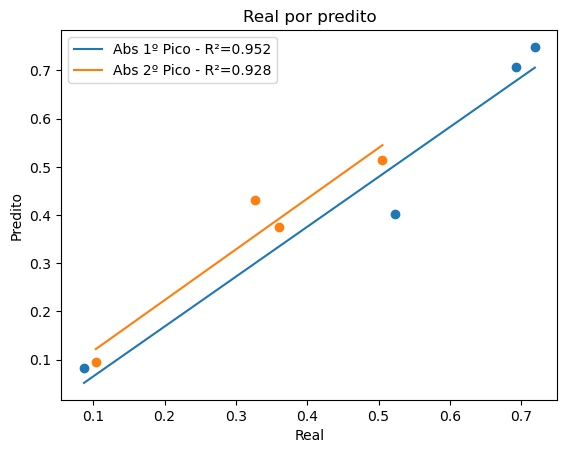

In [28]:
plt.scatter(y_true_1,y_pred_1),plt.scatter(y_true_2,y_pred_2)
plt.plot(x_plot_1,y_plot_1,label=f'Abs 1º Pico - R²={round(s1,3)}')
plt.plot(x_plot_2,y_plot_2,label=f'Abs 2º Pico - R²={round(s2,3)}')

plt.title('Real por predito'),plt.xlabel('Real'),plt.ylabel('Predito')

plt.legend()
# plt.savefig('figs/realXpredito_pca.png')
plt.show()

### Análise das épocas absorbância 1º e 2º pico - normalizados

In [85]:
X = df.iloc[:,1:9].values
y = df.iloc[:,-5:-3].values

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X)
normalizador_y.fit(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

model = MLP(num_dados_entrada=X_tensor.shape[1], neuronios_c1=50, neuronios_c2=20, num_targets=y_tensor.shape[1])

num_epochs = 20000

loss_values, acc_values = [], []

dataset = TensorDataset(X_tensor, y_tensor)

# Define o otimizador
optimizer = optim.SGD(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

min_loss = float('inf')
min_loss_value = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss,num_batches = 0.0,0  # Variável para armazenar a perda da época atual

    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    total,correct = 0,0
        
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # epoch_loss += loss.item()
        epoch_loss += np.sqrt(loss.item())
        
        mse = torch.mean((outputs - labels) ** 2)
        
        # _, predicted = torch.max(outputs.data,1)
        
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

        num_batches += 1
    
    epoch_loss /= num_batches 
    
    # epoch_loss = np.sqrt(epoch_loss)
    epoch_loss = epoch_loss
    
    # print(epoch_loss,mse.item())
    
    loss_values.append(epoch_loss)
    acc_values.append(np.sqrt(mse.item()))
    
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        min_loss_value = outputs
        min_loss_params = model.state_dict()
        min_loss_features = inputs

Valor mínimo da perda: 0.1425

Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.6667, 1.0000, 0.7143, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.2155, 0.5714, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.2500, 1.0000, 0.2857, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.2586, 0.5714, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 1.0000, 1.0000, 0.2857, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.6667, 1.0000, 0.2857, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.6667, 1.0000, 0.5714, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.5000, 1.0000, 0.2857, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.3448, 0.2000, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.6667, 1.0000, 0.8571, 0.0000, 0.0000])
Valores das feature

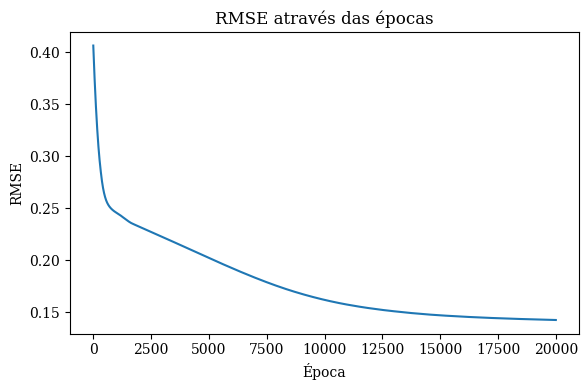

In [88]:
print(f"Valor mínimo da perda: {round(min_loss,4)}")

print()

for feature_values in min_loss_features:
    print(f"Valores das features: {feature_values}")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.figure(figsize=(6,4))

# plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.title('RMSE através das épocas')

# plt.subplot(1,2,2)
# plt.plot(range(1, num_epochs + 1), acc_values)
# plt.xlabel('Época')
# plt.ylabel('Accuracy')
# plt.title('Gráfico de acurácia')

plt.tight_layout()
# plt.savefig('figs/rmse.png')
plt.show()

### Absorbância 1 e 2 - PCA

#### PCA

In [29]:
X = df.iloc[:,1:9]

In [30]:
pca = sklearn.decomposition.PCA(n_components=2)

In [31]:
pca.fit(X)

PCA(n_components=2)

In [32]:
X_pca = pca.transform(X)

#### Regressão

In [33]:
novo_df = pd.DataFrame(X_pca,columns=['PC1','PC2'])
novo_df['Target 1'] = df['Abs 1º Pico']
novo_df['Target 2'] = df['Abs 2º Pico']

In [34]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(novo_df.columns)[:2]
TARGETS = ['Target 1','Target 2']

indices = novo_df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = novo_df.loc[indices_treino]
df_teste = novo_df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGETS, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGETS, axis=1)

In [35]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [36]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [37]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [38]:
y_prev = minha_MLP(X_treino)

In [39]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [40]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [41]:
NUM_EPOCAS = 20000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

19999 tensor(0.0001)


In [42]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [43]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [44]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [48]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {round(RMSE,6)}')

Loss do teste: 0.000101


#### Regressão através das épocas

In [70]:
X = novo_df.iloc[:,:2].values
y = novo_df.iloc[:,2:4].values

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X)
normalizador_y.fit(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

model = MLP(num_dados_entrada=X_tensor.shape[1], neuronios_c1=50, neuronios_c2=20, num_targets=y_tensor.shape[1])

num_epochs = 20000

loss_values, acc_values = [], []

dataset = TensorDataset(X_tensor, y_tensor)

# Define o otimizador
optimizer = optim.SGD(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

min_loss = float('inf')
min_loss_value = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss,num_batches = 0.0,0  # Variável para armazenar a perda da época atual

    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    total,correct = 0,0
        
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += np.sqrt(loss.item())
        
        mse = torch.mean((outputs - labels) ** 2)
        
        # _, predicted = torch.max(outputs.data,1)
        
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

        num_batches += 1
    
    epoch_loss /= num_batches 
    epoch_loss = epoch_loss
    
    loss_values.append(epoch_loss)
    acc_values.append(np.sqrt(mse.item()))
    
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        min_loss_value = outputs
        min_loss_params = model.state_dict()
        min_loss_features = inputs

Valor mínimo da perda: 0.159

Valores das features: tensor([ 0.3767, -0.3855])
Valores das features: tensor([ 0.5096, -0.3924])
Valores das features: tensor([ 0.4140, -0.3376])
Valores das features: tensor([ 0.4007, -0.3554])
Valores das features: tensor([ 0.4878, -0.3759])
Valores das features: tensor([0.8099, 0.4789])
Valores das features: tensor([ 0.4222, -0.3266])
Valores das features: tensor([-0.6315,  0.0773])
Valores das features: tensor([-0.6651,  0.1838])
Valores das features: tensor([ 0.3974, -0.3598])
Valores das features: tensor([ 0.1082, -0.3706])
Valores das features: tensor([-0.6926,  0.1234])
Valores das features: tensor([0.8547, 0.5842])
Valores das features: tensor([-0.7176,  0.1323])
Valores das features: tensor([ 0.4659, -0.3595])
Valores das features: tensor([-0.7065,  0.1284])
Valores das features: tensor([ 0.4057, -0.3487])
Valores das features: tensor([ 0.1110, -0.3716])
Valores das features: tensor([-0.6734,  0.1727])
Valores das features: tensor([-0.6816,  0.1

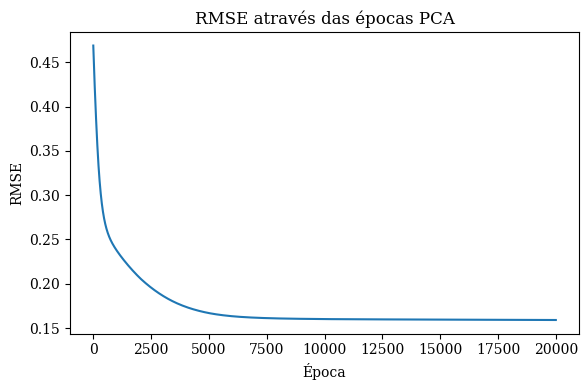

In [71]:
print(f"Valor mínimo da perda: {round(min_loss,4)}")

print()

for feature_values in min_loss_features:
    print(f"Valores das features: {feature_values}")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.figure(figsize=(6,4))

# plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.title('RMSE através das épocas PCA')

# plt.subplot(1,2,2)
# plt.plot(range(1, num_epochs + 1), acc_values)
# plt.xlabel('Época')
# plt.ylabel('Accuracy')
# plt.title('Gráfico de acurácia')

plt.tight_layout()
plt.savefig('figs/rmse_pca.png')
plt.show()

### Gráfico de Real x Predito PCA

In [49]:
y_true_1,y_true_2 = [],[]
y_pred_1,y_pred_2 = [],[]

for i in range(len(y_pred)):
    
    y_pred_1.append(y_pred[i][0])
    y_pred_2.append(y_pred[i][1])
    
    y_true_1.append(y_true[i][0])
    y_true_2.append(y_true[i][1])

In [50]:
model = LinearRegression()
m1 = model.fit(np.array(y_true_1).reshape((-1, 1)), y_pred_1)

model = LinearRegression()
m2 = model.fit(np.array(y_true_2).reshape((-1, 1)), y_pred_2)

In [51]:
def f(x,m):
    return m.intercept_ + x*m.coef_

In [52]:
x_plot_1 = np.linspace(min(y_true_1),max(y_true_1),10)
y_plot_1 = f(x_plot_1,m1)

x_plot_2 = np.linspace(min(y_true_2),max(y_true_2),10)
y_plot_2 = f(x_plot_2,m2)

In [53]:
s1,s2 = m1.score(np.array(y_true_1).reshape((-1, 1)),y_pred_1),m2.score(np.array(y_true_2).reshape((-1, 1)),y_pred_2)

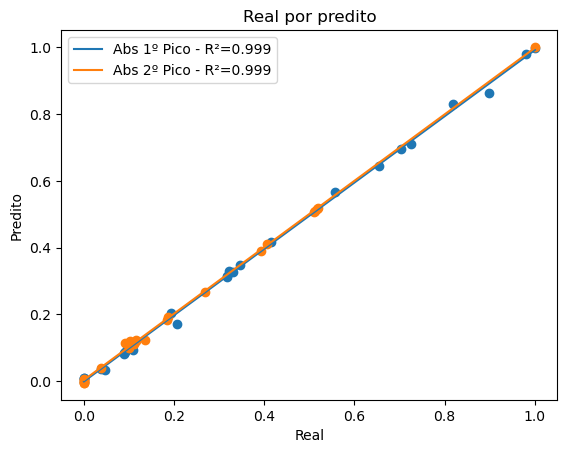

In [54]:
plt.scatter(y_true_1,y_pred_1),plt.scatter(y_true_2,y_pred_2)
plt.plot(x_plot_1,y_plot_1,label=f'Abs 1º Pico - R²={round(s1,3)}')
plt.plot(x_plot_2,y_plot_2,label=f'Abs 2º Pico - R²={round(s2,3)}')

plt.title('Real por predito'),plt.xlabel('Real'),plt.ylabel('Predito')

plt.legend()
# plt.savefig('figs/realXpredito_pca.png')
plt.show()

### Classificação

In [55]:
res_bool = []
for v in list(df['Resultado 2']):
    if v == 'NF':
        res_bool.append(False)
    else:
        res_bool.append(True)

In [56]:
df['Resultado Bool'] = res_bool

In [57]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:9]
TARGET = ['Resultado Bool']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [58]:
normalizador_x = MinMaxScaler()

normalizador_x.fit(X_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = np.array(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = np.array(y_teste)

In [59]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.bool)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.bool)

In [60]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [61]:
y_prev = minha_MLP(X_treino)

In [62]:
TAXA_DE_APRENDIZADO = 0.01

criterion = nn.MSELoss()
optimizer = optim.SGD(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [66]:
dataset = TensorDataset(X_treino, y_treino)

In [68]:
num_epochs = 20000

for epoch in range(num_epochs):
    for inputs, labels in dataset:
        
        outputs = minha_MLP(inputs)
        
        loss = torch.sqrt(criterion(outputs, labels.float()))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
print(f'Época {epoch+1} - RMSE: {loss.item()}')

Época 20000 - RMSE: nan


In [69]:
y_pred_pca = minha_MLP(X_treino)

In [70]:
y_pred_pca = np.array(y_pred_pca.detach().numpy()) > 0
y_pred_pca = y_pred_pca.tolist()

In [71]:
y_treino_pca = np.array(y_treino).copy()

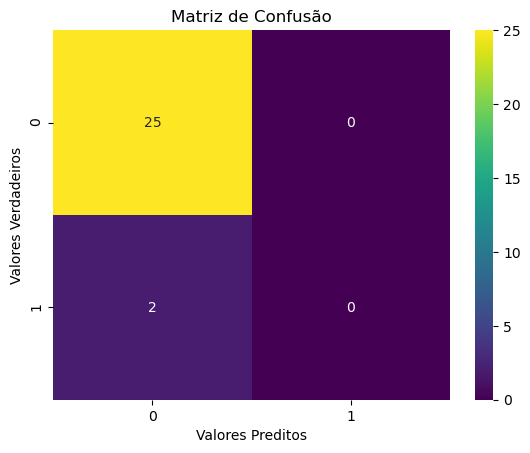

In [72]:
cm = confusion_matrix(y_treino_pca,y_pred_pca)

sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")

plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')

plt.show()

### Classificação PCA

In [91]:
novo_df['Resultado'] = list(df['Resultado Bool'])

In [92]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(novo_df.columns)[:2]
TARGET = ['Resultado']

indices = novo_df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = novo_df.loc[indices_treino]
df_teste = novo_df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [93]:
normalizador_x = MinMaxScaler()

normalizador_x.fit(X_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = np.array(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = np.array(y_teste)

In [94]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.bool)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.bool)

In [95]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [96]:
y_prev = minha_MLP(X_treino)

In [97]:
TAXA_DE_APRENDIZADO = 0.01

criterion = nn.MSELoss()
optimizer = optim.SGD(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [98]:
dataset = TensorDataset(X_treino, y_treino)

In [99]:
t, num_epochs = 0, 50

In [100]:
for epoch in range(num_epochs):
    for inputs, labels in dataset:
        
        outputs = minha_MLP(inputs)
        
        loss = torch.sqrt(criterion(outputs, labels.float()))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

t += num_epochs

print(f'Época {t} - RMSE: {loss.item()}')

Época 50 - RMSE: 0.015359915792942047


In [101]:
y_pred = minha_MLP(X_treino)

In [102]:
y_pred = np.array(y_pred.detach().numpy()) > 0
y_pred = y_pred.tolist()

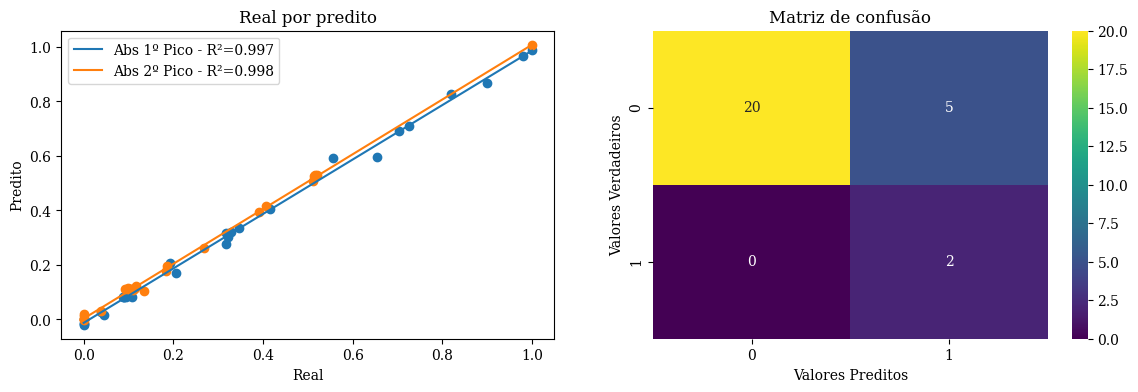

In [121]:
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.scatter(y_true_1,y_pred_1),plt.scatter(y_true_2,y_pred_2)
plt.plot(x_plot_1,y_plot_1,label=f'Abs 1º Pico - R²={round(s1,3)}')
plt.plot(x_plot_2,y_plot_2,label=f'Abs 2º Pico - R²={round(s2,3)}')

plt.title('Real por predito'),plt.xlabel('Real'),plt.ylabel('Predito')

plt.legend()

cm = confusion_matrix(y_treino_pca,y_pred_pca)

plt.subplot(122)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")

plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de confusão')

plt.savefig('figs/realXpredito_pca.png')

plt.show()